<a href="https://colab.research.google.com/github/fsilvestrim/thesis/blob/master/Geo_Cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utils

In [1]:
import re
import time
import random
import numpy as np
import scipy as sp
import pickle
import hashlib

import PIL
import cv2 as cv

from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from IPython.display import Image, display

%matplotlib inline

In [2]:
#%tensorflow_version 2.x

import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution

#disable_eager_execution()
enable_eager_execution()
print('Eager mode: %s' % tf.executing_eagerly())

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

2.4.1
Eager mode: True
Found GPU at: /device:GPU:0


In [3]:
def show_image(image, title=None):
  plt.figure(facecolor='white')
  ax = plt.gca()
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  plt.imshow(image.reshape(28, 28), cmap='Greys')
  if title is not None:
    plt.title(title)
  plt.show()

In [4]:
def show_prediction(image, truth, prediction, label_descriptions=None):
  prediction = np.argmax(prediction)
  prediction = prediction if label_descriptions is None else label_descriptions[prediction]
  truth = truth if label_descriptions is None else label_descriptions[truth]
  title = f"Prediction: {prediction} / Truth: {truth}"
  show_image(image, title)

In [66]:
def resize_image(image, size):
  height_zoom = size[1] / image.shape[0]
  width_zoom = size[0] / image.shape[1]
  image = sp.ndimage.zoom(image, (height_zoom, width_zoom), order=2)

  return image

In [67]:
def get_heatmap(cam, size, resize=True):
  heatmap = cam / np.max(cam)
 
  if resize:
    heatmap = resize_image(heatmap, size)
 
  return heatmap

In [6]:
def show_heatmap(img, cam, size, resize=True, title=None, detached=False, ax=None):
  img = img.reshape(size[0], size[1])
  heatmap = get_heatmap(cam, size, resize)

  # plot
  if ax is None:
    ax = plt.gca()

  ax.set_xticklabels([])
  ax.set_yticklabels([])

  if not detached:
    plt.figure(facecolor='white')
    plt.imshow(img, alpha=0.5, cmap='Greys')
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.axis('off')

    if title is not None:
      plt.title(title)
    
    plt.show()
  
  else:
    if title is not None:
      ax.set_title(title, fontdict=None, loc='center', color = "k")

    ax.imshow(img, alpha=0.5, cmap='Greys')
    ax.imshow(heatmap, cmap='jet', alpha=0.5)  

In [7]:
def plot_model_score(score, history):
  plt.figure(facecolor='white')
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.title("Loss: %.5f vs. Accuracy: %.5f" % (score[0], score[1]))
  plt.show() 

In [8]:
def load_model(name):
  model = keras.models.load_model("saved_model_%s" % name)
  history = pickle.load(open('saved_model_%s/history' % name, "rb"))

  return model, history

In [9]:
def save_model(model, history, name):
  model.save("saved_model_%s" % name)

  with open('saved_model_%s/history' % name, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [10]:
def get_cam_layers(model):
  last_conv_layer = None
  last_layers = []
  conv_layers = []
  for layer in reversed(model.layers):
      # check to see if the layer has a 4D output
      if len(layer.output_shape) == 4 and last_conv_layer is None:
        last_conv_layer = layer
        # print("Last Conv Layer: %s, filters %s" % (layer.name, layer.filters))

      if last_conv_layer is not None:
        conv_layers.insert(0, layer)
      else:
        last_layers.insert(0, layer)

  return conv_layers, last_layers

In [11]:
def get_layer(model, layer_name):
  for layer in model.layers:
    if layer.name == layer_name:
      return layer

  return None

In [12]:
def get_sample(test_set, idx=-1):
  test_idx = random.randint(0, len(test_set[0])) if idx < 0 else idx
  test_image = test_set[0][test_idx]
  test_label = np.argmax(test_set[1][test_idx])

  return test_image, test_label, test_idx

In [13]:
def predict(model, image):
  return model.predict(np.expand_dims(image, 0))

In [14]:
def get_prediction(model, test_set, idx=-1):
  x, y, idx = get_sample(test_set, idx)
  prediction = predict(model, x)

  return x, y, prediction, idx

In [15]:
def format_dataset(num_classes, train, test):
  (x_train, y_train), (x_test, y_test) = train, test

  print(x_train[0].shape)
  print(y_train[0])

  # Scale images to the [0, 1] range
  x_train = x_train.astype("float32") / 255
  x_test = x_test.astype("float32") / 255

  # Make sure images have shape (28, 28, 1)
  x_train = np.expand_dims(x_train, -1)
  x_test = np.expand_dims(x_test, -1)

  print("x_train shape:", x_train.shape)
  print(x_train.shape[0], "train samples")
  print(x_test.shape[0], "test samples")

  # convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)

  return (x_train, y_train), (x_test, y_test)

In [16]:
def copy_model(original_model, trainable=False):
  new_model = keras.models.clone_model(original_model)
  new_model.set_weights(original_model.get_weights())
  new_model.trainable = trainable
  return new_model

#MNIST

In [17]:
mnist_num_classes = 10
mnist_train, mnist_test = keras.datasets.mnist.load_data()
mnist_train, mnist_test = format_dataset(mnist_num_classes, mnist_train, mnist_test)

def create_mnist_model(name, input_shape, num_classes, train=None):
  model = keras.Sequential(
      [
          keras.Input(shape=input_shape),
      
          layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", name="mnist_first_conv"),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
      
          layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
          layers.Dropout(0.5),
      
          layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", name="mnist_last_conv"),
          
          # layers.GlobalAveragePooling2D(),
          layers.Flatten(),
          layers.Dense(num_classes, activation="softmax", name="mnist_output"),
      ]
  )

  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

11493376/11490434 [==============================] - 0s 0us/step
(28, 28)
5
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


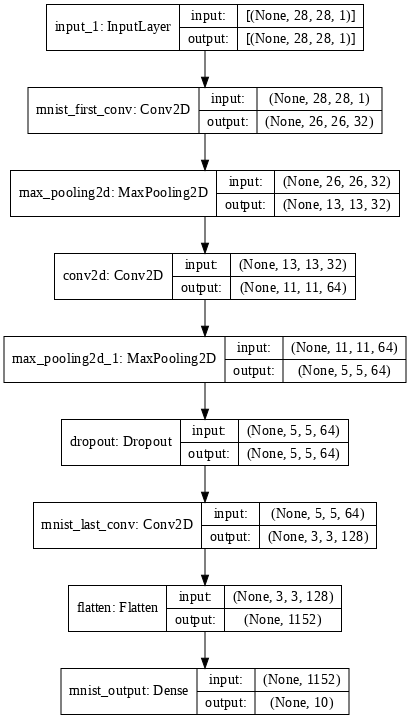

Epoch 1/15
422/422 [==============================] - 35s 7ms/step - loss: 0.6468 - accuracy: 0.8040 - val_loss: 0.0639 - val_accuracy: 0.9813
Epoch 2/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0970 - accuracy: 0.9709 - val_loss: 0.0441 - val_accuracy: 0.9872
Epoch 3/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0658 - accuracy: 0.9793 - val_loss: 0.0359 - val_accuracy: 0.9908
Epoch 4/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0509 - accuracy: 0.9836 - val_loss: 0.0348 - val_accuracy: 0.9890
Epoch 5/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0411 - accuracy: 0.9865 - val_loss: 0.0321 - val_accuracy: 0.9905
Epoch 6/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0394 - accuracy: 0.9879 - val_loss: 0.0345 - val_accuracy: 0.9905
Epoch 7/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0324 - accuracy: 0.9894 - val_loss: 0.0288 - val_accuracy: 0.9913
Epoch

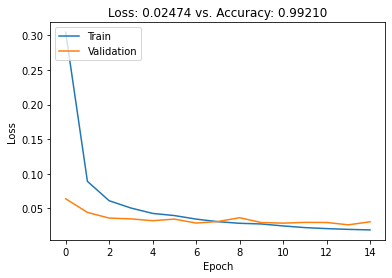

In [18]:
model_mnist = create_mnist_model("gap_shallow", (28, 28, 1), mnist_num_classes, mnist_train)
# model_mnist, history_mnist = load_model("gap_shallow")

display(keras.utils.plot_model(model_mnist, show_shapes=True, dpi=72))

# train
start_time = time.perf_counter()
history_mnist = model_mnist.fit(mnist_train[0], mnist_train[1], batch_size=128, epochs=15, validation_split=0.1)
print("Training took: %.2f seconds" % (time.perf_counter() - start_time))
# save_model(model_mnist, history_mnist, "gap_shallow")

# evaluate
score_mnist = model_mnist.evaluate(mnist_test[0], mnist_test[1], verbose=0)
plot_model_score(score_mnist, history_mnist.history)

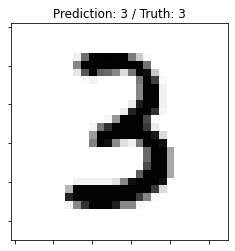

In [19]:
image, label, prediction, _ = get_prediction(model_mnist, mnist_test)
show_prediction(image, label, prediction)

#GEO

In [20]:
geo_dataset_proto = ("proto", "https://geo-cam.s3-eu-west-1.amazonaws.com/geocam.npz", ["vertical", "diagonal", "ellipse"])
geo_dataset_simple = ("simple", "https://geo-cam.s3-eu-west-1.amazonaws.com/simpledataset_dataset.npz", ["vertical", "horizontal", "diagonal", "ellipse", "greather_than", "lower_than"])
geo_dataset_round = ("round", "https://geo-cam.s3-eu-west-1.amazonaws.com/rounddataset_dataset.npz", ["vertical", "horizontal", "diagonal", "ellipse", "greather_than", "lower_than"])
geo_dataset_threesixty = ("threesixty", "https://geo-cam.s3-eu-west-1.amazonaws.com/threesixtydataset_dataset.npz", ["10", "20", "30", "40", "50", "60", "70", "80", "90", "100", "110", "120", "130", "140", "150", "160", "170", "180"])

def get_geo_dataset(name, filepath):
  path = tf.keras.utils.get_file(name, filepath)
  with np.load(path, allow_pickle=True) as f:
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']

    return (x_train, y_train), (x_test, y_test)

In [21]:
def create_geo_model(name, input_shape, num_classes):
  model = keras.Sequential(
      [
          keras.Input(shape=input_shape),
      
          layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu", name="geo_first_conv"),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
          layers.Dropout(0.4),
          layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
          # layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
          
          layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu", name="geo_last_conv"),
          # layers.GlobalAveragePooling2D(),
          layers.Flatten(),
          layers.Dense(num_classes, activation="softmax", name="geo_output"),
      ]
  )

  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

  return model

18841600/18841002 [==============================] - 1s 0us/step
(28, 28)
1
x_train shape: (4200, 28, 28, 1)
4200 train samples
1800 test samples


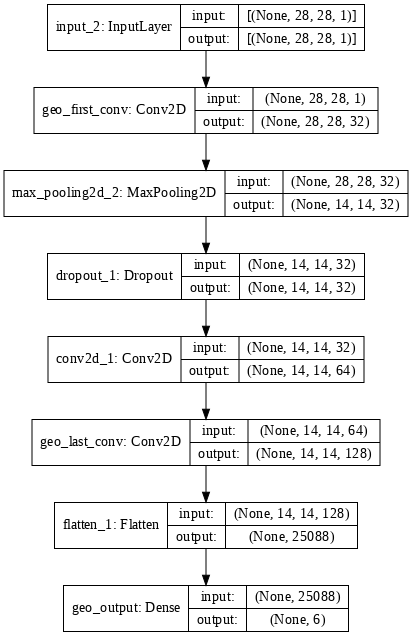

Epoch 1/15
25/25 [==============================] - 1s 23ms/step - loss: 1.5573 - accuracy: 0.3850 - val_loss: 1.1775 - val_accuracy: 0.5419
Epoch 2/15
25/25 [==============================] - 0s 10ms/step - loss: 0.9587 - accuracy: 0.6697 - val_loss: 0.4396 - val_accuracy: 0.8495
Epoch 3/15
25/25 [==============================] - 0s 10ms/step - loss: 0.4054 - accuracy: 0.8596 - val_loss: 0.2633 - val_accuracy: 0.9010
Epoch 4/15
25/25 [==============================] - 0s 10ms/step - loss: 0.2576 - accuracy: 0.9043 - val_loss: 0.2521 - val_accuracy: 0.9076
Epoch 5/15
25/25 [==============================] - 0s 11ms/step - loss: 0.1763 - accuracy: 0.9334 - val_loss: 0.2000 - val_accuracy: 0.9114
Epoch 6/15
25/25 [==============================] - 0s 10ms/step - loss: 0.1243 - accuracy: 0.9532 - val_loss: 0.1447 - val_accuracy: 0.9448
Epoch 7/15
25/25 [==============================] - 0s 10ms/step - loss: 0.0927 - accuracy: 0.9674 - val_loss: 0.1335 - val_accuracy: 0.9514
Epoch 8/15
25

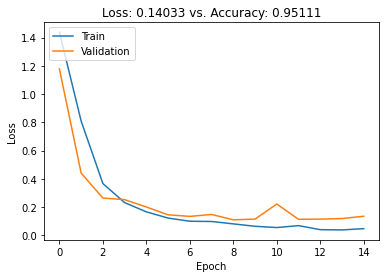

In [22]:
# dataset
dataset = geo_dataset_simple
geo_train, geo_test = get_geo_dataset(dataset[0], dataset[1])
geo_train, geo_test = format_dataset(len(dataset[2]), geo_train, geo_test)

# model
model_geo = create_geo_model("geocam", (28, 28, 1), len(dataset[2]))
# model_geo, history_geo = load_model("geo")

display(keras.utils.plot_model(model_geo, show_shapes=True, dpi=72))

start_time = time.perf_counter()
history_geo = model_geo.fit(geo_train[0], geo_train[1], batch_size=128, epochs=15, validation_split=0.25)
print("Training took: %.2f seconds" % (time.perf_counter() - start_time))
# save_model(model_geo, history_geo, "geo")

score_geo = model_geo.evaluate(geo_test[0], geo_test[1], verbose=0)
plot_model_score(score_geo, history_geo.history)

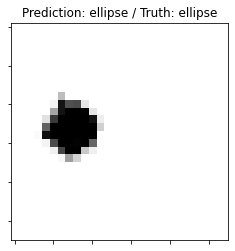

In [23]:
image, truth, prediction, _ = get_prediction(model_geo, geo_test)
show_prediction(image, truth, prediction, dataset[2])

# Transfer-learning


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
geo_first_conv (Conv2D)         (None, 28, 28, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 32)   0           geo_first_conv[1][0]             
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 14, 14, 32)   0           max_pooling2d_2[1][0]            
____________________________________________________________________________________________

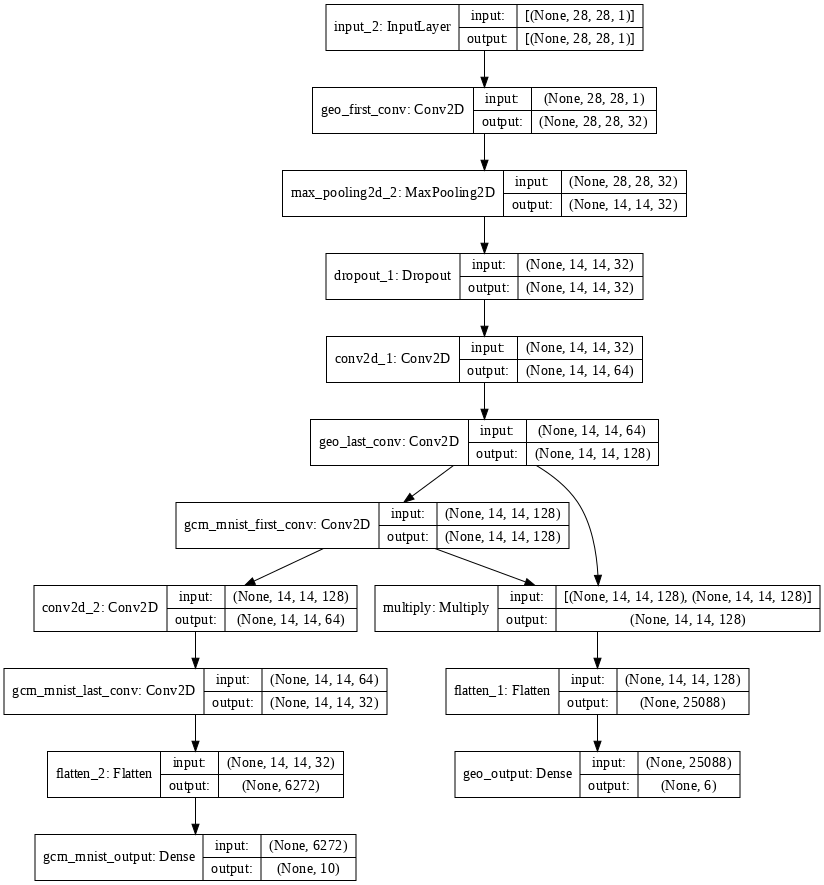

Epoch 1/5
375/375 [==============================] - 5s 11ms/step - loss: 0.3443 - accuracy: 0.8925 - val_loss: 0.0817 - val_accuracy: 0.9744
Epoch 2/5
375/375 [==============================] - 4s 10ms/step - loss: 0.0828 - accuracy: 0.9746 - val_loss: 0.0553 - val_accuracy: 0.9842
Epoch 3/5
375/375 [==============================] - 4s 10ms/step - loss: 0.0655 - accuracy: 0.9791 - val_loss: 0.0665 - val_accuracy: 0.9799
Epoch 4/5
375/375 [==============================] - 4s 10ms/step - loss: 0.0597 - accuracy: 0.9810 - val_loss: 0.0755 - val_accuracy: 0.9800
Epoch 5/5
375/375 [==============================] - 4s 10ms/step - loss: 0.0579 - accuracy: 0.9826 - val_loss: 0.0790 - val_accuracy: 0.9801
Training took: 20.70 seconds


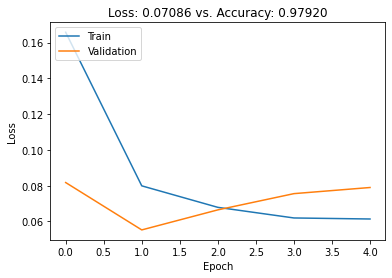

In [24]:
geo_model_copy = copy_model(model_geo, False)
input = geo_model_copy.input
geo_last, geo2_last, last = None, None, None

# utilize a lambda layer to convert the 3 channel input to a
# grayscale representation
# x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)
  
for layer in get_cam_layers(geo_model_copy)[0]:
  layer.trainable = False
  geo_last = layer(input) if geo_last is None else layer(geo_last)

# merged_input = layers.Add()([geo_last, input])
# geo_last = layers.Dense(6272, activation='relu')(geo_last)
# last = layers.Reshape((28,28,784))(last)
# last = geo_last_cnn
last = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu", name="gcm_mnist_first_conv")(geo_last)
piggi_back = layers.Multiply()([geo_last, last])

for layer in get_cam_layers(geo_model_copy)[1]:
  layer.trainable = False
  geo2_last = layer(piggi_back) if geo2_last is None else layer(geo2_last)

# last = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2))(last)
# last = layers.Dropout(0.4)(last)
last = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(last)
# last = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2))(last)
# last = layers.Dropout(0.4)(last)
last = layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu", name="gcm_mnist_last_conv")(last)
last = layers.Flatten()(last)
# last = layers.Multiply()([last, geo_last]) #geo
last = layers.Dense(mnist_num_classes, activation="softmax", name="gcm_mnist_output")(last)

model_gcm = Model(inputs=input, outputs=last)
model_gcm_complete = Model(inputs=input, outputs=[last, geo2_last])

opt = keras.optimizers.Adam(learning_rate=0.004)
model_gcm.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

model_gcm_complete.summary()
display(keras.utils.plot_model(model_gcm_complete, show_shapes=True, dpi=72))

# train
start_time = time.perf_counter()
history_geocam = model_gcm.fit(mnist_train[0], mnist_train[1], batch_size=128, epochs=5, validation_split=0.2)
print("Training took: %.2f seconds" % (time.perf_counter() - start_time))

# evaluate
score_gcm = model_gcm.evaluate(mnist_test[0], mnist_test[1], verbose=0)
plot_model_score(score_gcm, history_geocam.history)

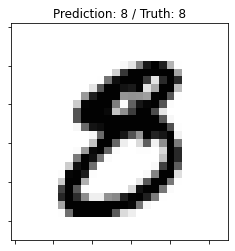

In [25]:
image, label, prediction, _ = get_prediction(model_gcm, mnist_test)
show_prediction(image, label, prediction)

# CAMs

In [26]:
def cam(model, conv_outputs, prediction_idx):
  cam_layers = get_cam_layers(model)
  class_weights = cam_layers[0][-1].get_weights()[0]
  conv_outputs = conv_outputs[0, :, :, :]
  cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
  for index, weight in enumerate(class_weights[:, prediction_idx]):
    cam += weight * conv_outputs[:, :, index]

  return cam

In [27]:
def grad_cam_m(image, cam_model, prediction_idx=-1, prediction_output=-1):
  with tf.GradientTape() as tape:
    conv_output, predictions = cam_model(np.expand_dims(image, 0))
    if len(predictions) > 1:
      predictions = predictions[prediction_output] if prediction_output >= 0 else predictions[0]
    prediction_idx = np.argmax(predictions) if prediction_idx < 0 else prediction_idx
    output = predictions[:, prediction_idx]

  grads = tape.gradient(output, conv_output)
  # print(f"{prediction_idx} -> {hashlib.sha256(grads).hexdigest().upper()}")
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  conv_output = conv_output.numpy()[0]
  pooled_grads = pooled_grads.numpy()

  for i in range(pooled_grads.shape[-1]):
    conv_output[:, :, i] *= pooled_grads[i]

  cam = np.mean(conv_output, axis=-1)

  return cam, conv_output, predictions, pooled_grads

def grad_cam(image, model, con_layer_idx=-1, prediction_idx=-1):
  cam_layers = get_cam_layers(model)
  conv_layer = cam_layers[0][con_layer_idx]
  cam_model = Model([model.inputs], [conv_layer.get_output_at(0), model.output])

  return grad_cam_m(image, cam_model, prediction_idx)

In [28]:
def grad_cam_pp_m(image, cam_model, prediction_idx=-1):
  with tf.GradientTape() as tape1:
      with tf.GradientTape() as tape2:
          with tf.GradientTape() as tape3:
              conv_output, predictions = cam_model(np.expand_dims(image, 0))
              if len(predictions) > 1:
                predictions = predictions[prediction_output] if prediction_output >= 0 else predictions[0]
              prediction_idx = np.argmax(predictions) if prediction_idx < 0 else prediction_idx
              output = predictions[:, prediction_idx]
              conv_first_grad = tape3.gradient(output, conv_output)
          conv_second_grad = tape2.gradient(conv_first_grad, conv_output)
      conv_third_grad = tape1.gradient(conv_second_grad, conv_output)

  global_sum = np.sum(conv_output, axis=(0, 1, 2))

  alpha_num = conv_second_grad[0]
  alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
  alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)

  alphas = alpha_num/alpha_denom
  alpha_normalization_constant = np.sum(alphas, axis=(0,1))
  alphas /= alpha_normalization_constant

  weights = np.maximum(conv_first_grad[0], 0.0)

  deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
  cam = np.sum(deep_linearization_weights*conv_output[0], axis=2)

  return cam, conv_output, predictions, (conv_first_grad, conv_second_grad, conv_third_grad)

def grad_cam_pp(image, model, con_layer_idx=-1, prediction_idx=-1):
  cam_layers = get_cam_layers(model)
  conv_layer = cam_layers[0][con_layer_idx]
  cam_model = Model([model.inputs], [conv_layer.get_output_at(0), model.output])

  return grad_cam_pp_m(image, cam_model, prediction_idx)

# Experiments

In [29]:
# Agregate the descriptions of 500 numbers 5 and see if the descriptions match -> most likely explanation -> general descriptions of a number 5 and general description (ambiguity in the knowledge datatset)

# 1 - go back to same architecture G1 -> M1 -> M2 
# 2 - cam from the first layer of M1 -> mask 
# 3 - check all cam action maps from last layer of G1 -> G2
# 4 - check 

In [30]:
# geo2 (sliced) model (from model_gcm - transfer learning) for cam prediction
model_geocam = Model([model_geo.inputs], [get_layer(model_geo, "geo_last_conv").get_output_at(0), model_geo.output])

model_gcmcam = Model([model_gcm_complete.inputs], 
                     [get_layer(model_gcm_complete, "geo_last_conv").get_output_at(1), 
                      model_gcm_complete.output])

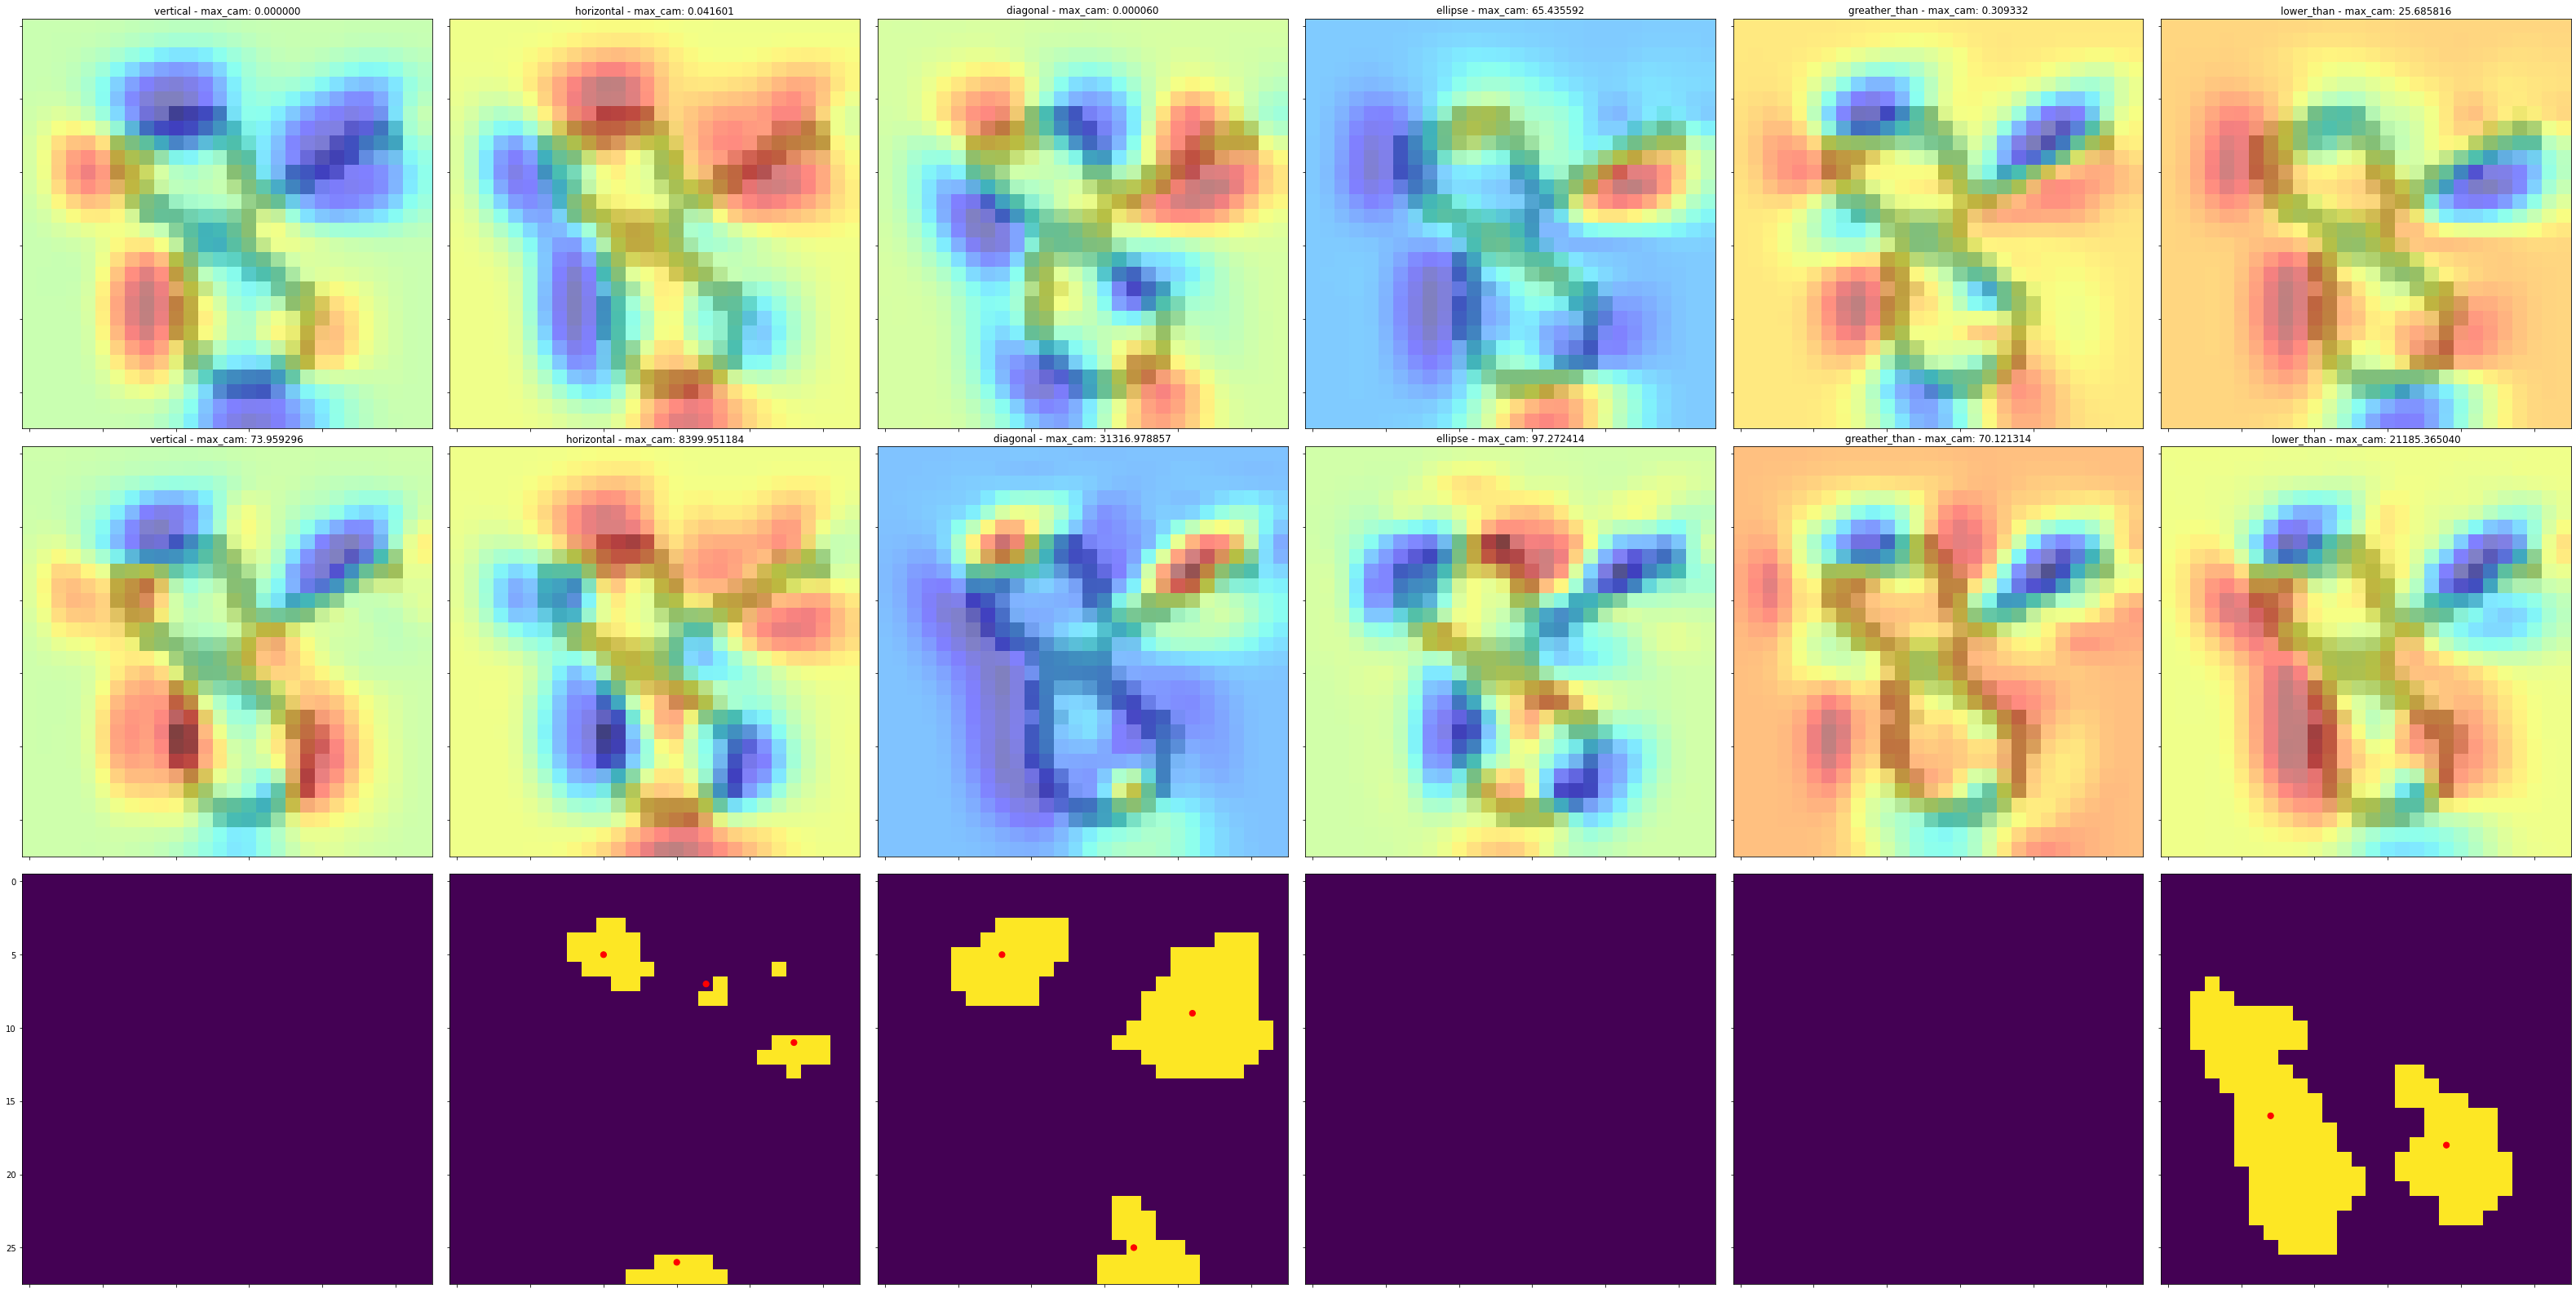

In [185]:
from mpl_toolkits.axes_grid1 import ImageGrid

# prediction based on conv output (5056, 6146, 2365, 2587)
test_image, test_label, test_idx = get_sample(mnist_test)
mnist_gcm_predictions = predict(model_gcm, test_image)
mnist_gcm_prediction = np.argmax(mnist_gcm_predictions)

# show_image(test_image, f"idx: {test_idx}")
assert test_label == mnist_gcm_prediction, "Missmatched ids. Wanted %d, received %d" % (test_label, mnist_gcm_prediction)

geo_classes = len(dataset[2])

# mnist geo encoded activation
# gcm_cam, gcm_conv_actv, predictions, _ = grad_cam_m(test_image, gcmcam_model, -1, 1)
# prediction = np.argmax(predictions)
# assert test_label == prediction, "Missmatched ids. Wanted %d, received %d" % (test_label, prediction)
# show_heatmap(test_image, gcm_cam, (28, 28, 1), True)

# gcm_cam_mask = np.max(gcm_cam) - gcm_cam
# fig = plt.figure(facecolor='white', figsize=(28, 28))
# fig, axes = plt.subplots(2, geo_classes, constrained_layout=True)
fig = plt.figure(figsize=(56, 56))
grid = ImageGrid(fig, 111,  # similar to subplot(141)
                     nrows_ncols=(3, geo_classes),
                     axes_pad=0.3,
                     label_mode="1",
                     )

# pure geo
image_idx = 0
for category in range(geo_classes):
  cam, _, _, _ = grad_cam_m(test_image, model_geocam, category)
  title = f"{dataset[2][category]} - max_cam: {np.max(cam) * 100000000:.6f}"
  show_heatmap(test_image, cam, (28, 28, 1), True, title, detached=True, ax=grid[image_idx])
  image_idx += 1

# masks (geo)
cam_activations = dict()
min_cam_activation, max_cam_activation = 0, 0
for category in range(geo_classes):
  cam, _, _, _ = grad_cam_m(test_image, model_gcmcam, category, 1)
  cam_activations[category] = cam
  min, max = np.min(cam), np.max(cam)
  # print(f"{min} - {min_cam_activation} | {max} - {max_cam_activation}")
  min_cam_activation = np.minimum(min, min_cam_activation)
  max_cam_activation = np.maximum(max, max_cam_activation)
  title = f"{dataset[2][category]} - max_cam: {np.max(cam) * 100000000:.6f}"
  show_heatmap(test_image, cam, (28, 28, 1), True, title, detached=True, ax=grid[image_idx])
  image_idx += 1

for category in range(geo_classes):
  cam = cam_activations[category]
  cam = (cam - min_cam_activation) / (max_cam_activation - min_cam_activation)
  
  cam = resize_image(cam, (28, 28)) * 255
  _, cam = cv.threshold(cam, 150, 255, cv.THRESH_BINARY)
  cv_img = np.array(cam, dtype = np.uint8)
  contours, _ = cv.findContours(cv_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  grid[image_idx].imshow(cv_img)
  
  for i in range(len(contours)):
    moments = cv.moments(contours[i])
    if moments['m00'] > 0:
      center = (int(moments['m10']/moments['m00']), int(moments['m01']/moments['m00']))
      circle1 = plt.Circle(center, 0.2, color='r')
      grid[image_idx].add_patch(circle1)
  
  image_idx += 1

plt.show()

# Prediction
# sorted_indexes = np.flip(np.argsort(geocam_gcm_cam_predictions[0]))
# percentages = np.round(geocam_gcm_cam_predictions[0] / geocam_gcm_cam_predictions[0][sorted_indexes[0]], 5)

# print(f"1st : {dataset[2][sorted_indexes[0]]} ({percentages[sorted_indexes[0]] * 100:.2f}%)")
# print(f"2nd : {dataset[2][sorted_indexes[1]]} ({percentages[sorted_indexes[1]] * 100:.2f}%)")
# print(f"3rd : {dataset[2][sorted_indexes[2]]} ({percentages[sorted_indexes[2]] * 100:.2f}%)")

# Metrics

In [186]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from tqdm import tqdm 

digit_decomposition_categories = ["vertical", "horizontal", "diagonal", "ellipse", "greather_than", "lower_than"]
digits_descriptions = [
  ["ellipse"], #0
  ["vertical", "diagonal"], #1
  ["horizontal", "diagonal"], #2
  ["greather_than", "lower_than", "ellipse"], #3
  ["vertical", "horizontal"], #4
  ["greather_than", "ellipse", "vertical", "horizontal"], #5
  ["diagonal", "vertical", "ellipse"], #6
  ["diagonal", "vertical", "horizontal"], #7
  ["ellipse"], #8
  ["ellipse", "diagonal", "vertical"], #9
]

validation_amount_per_category = 100
metrics, y_true, y_pred = dict(), dict(), dict()

with tqdm(total=(validation_amount_per_category * mnist_num_classes), position=0, leave=True) as pbar:
  for category in range(mnist_num_classes):
    metrics[category] = dict()
    
    decomposed_category = np.zeros(shape=(mnist_num_classes))
    decomposed_category[category] = 1
    
    y_true[category] = np.zeros(shape=(validation_amount_per_category))
    y_pred[category] = np.zeros(shape=(validation_amount_per_category))

    for i in range(validation_amount_per_category):
      validation_idx = random.choice(np.argwhere(np.equal(mnist_test[1], decomposed_category).all(1)))[0]

      # cam
      test_mnist_image = mnist_test[0][validation_idx]
      geocam_gcm_cam, geocam_gcm_cam_conv_output, geocam_gcm_cam_predictions, _ = grad_cam_m(test_mnist_image, model_gcmcam, -1, 1)
      
      # prediction
      possible_decomposition_labels = digits_descriptions[category]
      prediction_label = dataset[2][np.argmax(geocam_gcm_cam_predictions)]
      acceptable = prediction_label in possible_decomposition_labels
      y_pred[category][i] = np.int0(acceptable)

      pbar.update()

    # metrics per category
    metrics[category]['accuracy']   = accuracy_score(y_true[category], y_pred[category])
    metrics[category]['precision']  = precision_score(y_true[category], y_pred[category], average='weighted', zero_division=0)
    metrics[category]['recall']     = recall_score(y_true[category], y_pred[category], average='weighted', zero_division=0)
    metrics[category]['f1']         = f1_score(y_true[category], y_pred[category], average='weighted', zero_division=0)

# out
print("\n\nMETRICS:")

# macro metrics
print("\nMacro:")
macro_metrics = dict()
for cat in metrics:
  for key in metrics[cat]:
    macro_metrics[key] = macro_metrics.get(key) or []
    macro_metrics[key].append(metrics[cat][key])
  
for key in macro_metrics:
  print(f"- {key}: {np.average(macro_metrics[key]):.2f}")

# micro metrics
print("\nMicro:")
for cat in metrics:
  all_metrics = ', '.join([f"{key}:{np.average(metrics[cat][key]):.2f}" for key in metrics[cat]])
  print(f"- {cat}: {all_metrics}")

100%|██████████| 1000/1000 [00:09<00:00, 106.83it/s]



METRICS:

Macro:
- accuracy: 0.72
- precision: 1.00
- recall: 0.72
- f1: 0.82

Micro:
- 0: accuracy:1.00, precision:1.00, recall:1.00, f1:1.00
- 1: accuracy:0.87, precision:1.00, recall:0.87, f1:0.93
- 2: accuracy:0.33, precision:1.00, recall:0.33, f1:0.50
- 3: accuracy:0.67, precision:1.00, recall:0.67, f1:0.80
- 4: accuracy:0.67, precision:1.00, recall:0.67, f1:0.80
- 5: accuracy:0.72, precision:1.00, recall:0.72, f1:0.84
- 6: accuracy:0.63, precision:1.00, recall:0.63, f1:0.77
- 7: accuracy:0.52, precision:1.00, recall:0.52, f1:0.68
- 8: accuracy:0.96, precision:1.00, recall:0.96, f1:0.98
- 9: accuracy:0.81, precision:1.00, recall:0.81, f1:0.90


# Archive

In [33]:
raise Exception('do not run any further')

Exception: ignored

In [ ]:
# verifying transfer learning
print(f"geo conv weights: {hashlib.sha256(get_layer(model_geo, 'geo_last_conv').get_weights()[0]).hexdigest().upper()}")
print(f"gcm1 conv weights: {hashlib.sha256(get_layer(model_gcm, 'geo_last_conv').get_weights()[0]).hexdigest().upper()}")
print(f"gcm2 conv weights: {hashlib.sha256(get_layer(model_gcm_complete, 'geo_last_conv').get_weights()[0]).hexdigest().upper()}")

print(f"geo conv biases: {hashlib.sha256(get_layer(model_geo, 'geo_last_conv').get_weights()[1]).hexdigest().upper()}")
print(f"gcm1 conv biases: {hashlib.sha256(get_layer(model_gcm, 'geo_last_conv').get_weights()[1]).hexdigest().upper()}")
print(f"gcm2 conv biases: {hashlib.sha256(get_layer(model_gcm_complete, 'geo_last_conv').get_weights()[1]).hexdigest().upper()}")

test_image, test_label, test_idx = get_sample(mnist_test)
test_geo = Model([model_geo.inputs], [get_layer(model_geo, 'geo_last_conv').get_output_at(0), model_geo.output])
test_gcm = Model([model_gcm_complete.inputs], [get_layer(model_gcm_complete, 'geo_last_conv').get_output_at(1), 
                                               get_layer(model_gcm_complete, "geo_output").get_output_at(0)])
test_gcm_ = Model([model_gcm_complete.inputs], [get_layer(model_gcm_complete, 'gcm_mnist_first_conv').get_output_at(0), 
                                               get_layer(model_gcm_complete, "geo_output").get_output_at(0)])

print(f"geo conv activations: {hashlib.sha256(test_geo(np.expand_dims(test_image, 0))[0]).hexdigest().upper()}")
print(f"gcm conv activations: {hashlib.sha256(test_gcm(np.expand_dims(test_image, 0))[0]).hexdigest().upper()}")
print(f"gcm alterate conv activations: {hashlib.sha256(test_gcm_(np.expand_dims(test_image, 0))[0]).hexdigest().upper()}")

In [ ]:
# debugging cams and values
test_ids = {
        "1": 3455,
        "4": 6195,
        "0": 3710,
        "6": 6187,
        "7": 6606,
        "5": 6148,
        "9": 5622,
    }

test_idx = 6
test_mnist_idx = test_ids[f"{test_idx}"]
test_mnist_image = mnist_test[0][test_mnist_idx]
# show_image(test_mnist_image)

# GCM (Transfer learned network - init geo, end mnist)
# gcm_mnist_image, _, prediction, test_img_idx = get_prediction(model_gcm, mnist_test, test_idx)
# gcm_prediction_idx = np.argmax(prediction)
gcm_mnist_cam, gcm_conv_output, gcm_mnist_prediction, _ = grad_cam_pp(test_mnist_image, model_gcm, -3)
print(f"conv output hash: {hashlib.sha256(gcm_conv_output.numpy()).hexdigest().upper()}")

title = f"MNIST prediction: {gcm_mnist_prediction} (truth: {test_idx})"
show_heatmap(test_mnist_image, gcm_mnist_cam, (28, 28, 1), True, title)

assert test_idx == gcm_mnist_prediction, "Missmatched ids. Wanted %d, received %d" % (test_idx, gcm_mnist_prediction)

In [ ]:
# 1) prediction based on conv output
test_image, test_label = get_sample(mnist_test)

cam_layer = get_cam_layer(model_gcm, "conv2d_5")
cam_model = Model([model_gcm.inputs], [cam_layer.get_output_at(1), model_gcm.output])
gcm_mnist_cam, gcm_conv_output, gcm_mnist_prediction, _ = grad_cam_pp_m(test_image, cam_model)
# print(f"conv output hash: {hashlib.sha256(gcm_conv_output.numpy()).hexdigest().upper()}")
assert test_label == gcm_mnist_prediction, "Missmatched ids. Wanted %d, received %d" % (test_idx, test_label)

# Prediction
labels = dataset[2]
gcg_predictions = model_geo_2.predict(gcm_conv_output)
sorted_indexes = np.flip(np.argsort(gcg_predictions[0]))
percentages = gcg_predictions[0] / gcg_predictions[0][sorted_indexes[0]]

print(f"1st : {labels[sorted_indexes[0]]} ({percentages[sorted_indexes[0]] * 100:.2f}%)")
print(f"2nd : {labels[sorted_indexes[1]]} ({percentages[sorted_indexes[1]] * 100:.2f}%)")
print(f"3rd : {labels[sorted_indexes[2]]} ({percentages[sorted_indexes[2]] * 100:.2f}%)")

# Debug (CAM projection)
gcg_mnist_cam = cam_1(model_geo, gcm_conv_output, sorted_indexes[0])
show_heatmap(test_image, gcg_mnist_cam, (28, 28, 1), True)

In [ ]:
# 2) prediction based on cam heatmap (SHOULD NOT WORK)

test_image, test_label = get_sample(mnist_test, 6187)
gcm_mnist_cam, gcm_conv_output, gcm_mnist_prediction, _ = grad_cam_pp(test_image, model_gcm)
heatmap = get_heatmap(gcm_mnist_cam, (28, 28)).reshape(28, 28, 1) * 255
prediction = predict(model_geo, heatmap)

show_image(heatmap)

labels = dataset[2]
sorted_indexes = np.flip(np.argsort(prediction[0]))
percentages = prediction[0] / prediction[0][sorted_indexes[0]]

print(f"1st : {labels[sorted_indexes[0]]} ({percentages[sorted_indexes[0]] * 100:.2f}%)")
print(f"2nd : {labels[sorted_indexes[1]]} ({percentages[sorted_indexes[1]] * 100:.2f}%)")
print(f"3rd : {labels[sorted_indexes[2]]} ({percentages[sorted_indexes[2]] * 100:.2f}%)")

plt.figure(facecolor='white')
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.imshow(test_image.reshape(28, 28), alpha=0.5, cmap='Greys')
plt.imshow(heatmap.reshape(28, 28), cmap='jet', alpha=0.5)
plt.show()  